<a href="https://colab.research.google.com/github/NicoleFalcao11/CNN-Based-Crop-Disease-Detection/blob/main/CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
#from tensorflow.keras import models , layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import models , layers
#from keras.models import Sequential, load_model

In [ ]:
IMAGE_SIZE = 256
BATCH = 32
CHANNELS = 3

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory (
    "/content/drive/MyDrive/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH

)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
print(class_names)
len(dataset)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


68

(32, 256, 256, 3)
[0 0 0 1 1 1 1 0 2 1 1 0 0 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0 0 1 0 1]
[[[175. 169. 171.]
  [170. 164. 166.]
  [177. 171. 173.]
  ...
  [202. 197. 201.]
  [187. 182. 186.]
  [189. 184. 188.]]

 [[169. 163. 165.]
  [166. 160. 162.]
  [174. 168. 170.]
  ...
  [210. 205. 209.]
  [200. 195. 199.]
  [194. 189. 193.]]

 [[168. 162. 164.]
  [166. 160. 162.]
  [175. 169. 171.]
  ...
  [205. 200. 204.]
  [200. 195. 199.]
  [184. 179. 183.]]

 ...

 [[116. 107. 110.]
  [114. 105. 108.]
  [120. 111. 114.]
  ...
  [128. 121. 128.]
  [130. 123. 130.]
  [130. 123. 130.]]

 [[113. 104. 107.]
  [120. 111. 114.]
  [119. 110. 113.]
  ...
  [138. 131. 138.]
  [132. 125. 132.]
  [122. 115. 122.]]

 [[107.  98. 101.]
  [120. 111. 114.]
  [114. 105. 108.]
  ...
  [127. 120. 127.]
  [137. 130. 137.]
  [142. 135. 142.]]]


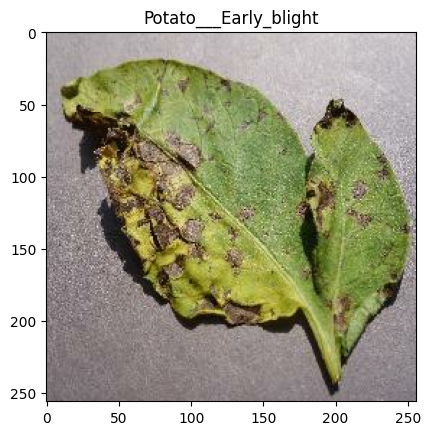

In [ ]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    print(image_batch[0].numpy())
    plt.imshow(image_batch[0].numpy()) #For Float
    plt.title(class_names[label_batch[0]])
    plt.imshow(image_batch[0].numpy().astype("uint8"))

In [ ]:
#For Understanding
train_size = 0.8
print(len(dataset)*train_size)
train_ds =  dataset.take(54)

54.400000000000006


In [ ]:
test_ds = dataset.skip(54)
print(len(test_ds))
valid_size = 0.1
len(dataset)*valid_size

14


6.800000000000001

In [ ]:
valid_ds = test_ds.take(6) #10% of test = validation
len(valid_ds)

6

In [ ]:
test_ds = test_ds.skip(6) #10% of test = test
len(test_ds)

8

In [ ]:
def get_DS_partitions (dataset , train_split=0.8 , valid_split=0.1 , test_split=0.1, shuffle = True,shuffle_size=10000):
    ds_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size , seed=12)

    train_size = int(train_split*ds_size)
    train_dataset = dataset.take(train_size)

    val_size = int(valid_split*ds_size)
    valid_dataset = dataset.skip(train_size).take(val_size)

    test_size = int(test_split*ds_size)
    test_dataset = dataset.skip(train_size).skip(val_size)

    return train_dataset , valid_dataset , test_dataset

In [ ]:
train_dataset , valid_dataset , test_dataset = get_DS_partitions(dataset)

In [ ]:
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))
#Values same as we calculated above are obtained
#From 2000+ images divided into 32 Batchs , each batch containing 68 images
#80% = 54 = train , 20% = validation and test , 10% of that 20% = 6 = valid
#remaining = test

54
6
8


In [ ]:
#Caching and Pre-fetching
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
valid_dataset = valid_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

#Datasets Optimised For Better and Faster Training

In [ ]:
#Resizing and Scaling LAYER , numpy array is bet 0 to 255 which is an RGB scale , dividing by 255 to get that bet 0 to 1
resize_rescale_layer = tf.keras.Sequential(
    [layers.experimental.preprocessing.Resizing(IMAGE_SIZE , IMAGE_SIZE),
     layers.experimental.preprocessing.Rescaling(1.0/255)]
)

In [ ]:
#Data Augmentation LAYER
data_augmentation_layer = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
train_dataset = train_dataset.map(
    lambda x , y: (data_augmentation_layer(x ,training=True) , y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BATCH, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_rescale_layer,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_dataset,
    batch_size=BATCH,
    validation_data=valid_dataset,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 486s 5s/step - loss: 0.8996 - accuracy: 0.4803 - val_loss: 0.8286 - val_accuracy: 0.4740
Epoch 2/50
54/54 [==============================] - 235s 4s/step - loss: 0.7806 - accuracy: 0.5735 - val_loss: 0.5475 - val_accuracy: 0.7865
Epoch 3/50
54/54 [==============================] - 235s 4s/step - loss: 0.5036 - accuracy: 0.7656 - val_loss: 0.3337 - val_accuracy: 0.8646
Epoch 4/50
54/54 [==============================] - 231s 4s/step - loss: 0.3784 - accuracy: 0.8397 - val_loss: 0.3014 - val_accuracy: 0.8646
Epoch 5/50
54/54 [==============================] - 229s 4s/step - loss: 0.2838 - accuracy: 0.8791 - val_loss: 0.2534 - val_accuracy: 0.9219
Epoch 6/50
54/54 [==============================] - 228s 4s/step - loss: 0.2737 - accuracy: 0.8958 - val_loss: 0.2775 - val_accuracy: 0.8854
Epoch 7/50
54/54 [==============================] - 233s 4s/step - loss: 0.1818 - accuracy: 0.9294 - val_loss: 0.2252 - val_accuracy: 0.9062
Epoch 8/50
54

In [ ]:
scores = model.evaluate(test_dataset)

8/8 [==============================] - 15s 985ms/step - loss: 0.0590 - accuracy: 0.9766


In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history['loss'][:5]

[0.8996146321296692,
 0.7805885076522827,
 0.5036348700523376,
 0.3783723711967468,
 0.28376156091690063]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

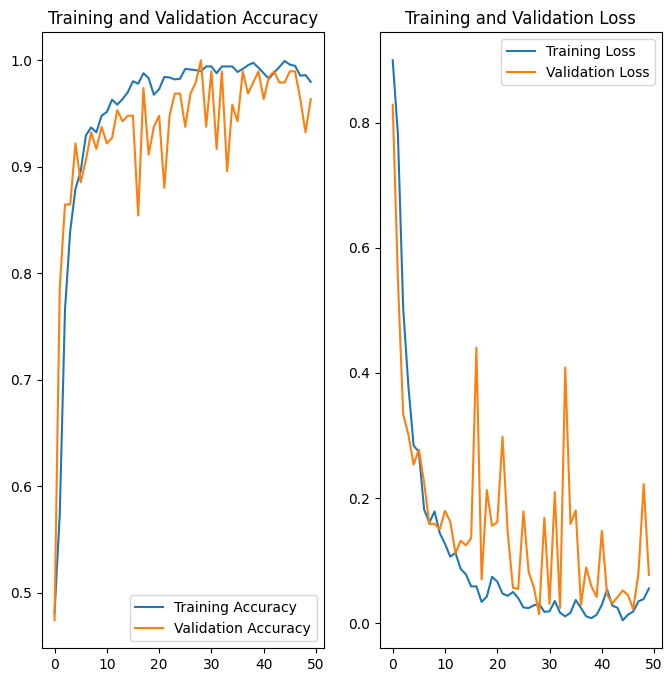

In [ ]:
EPOCHS = 50
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 2s 2s/step
predicted label: Potato___healthy


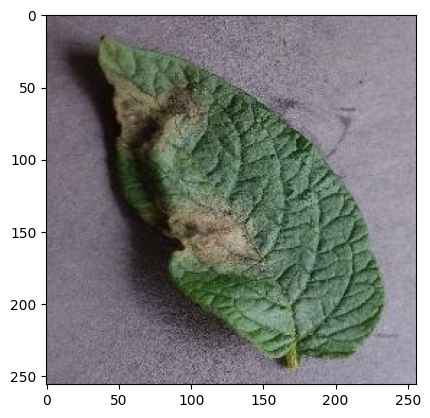

In [ ]:
import numpy as np
for images_batch, labels_batch in test_dataset.take(1):

    first_image = images_batch[1].numpy().astype('uint8')
    first_label = labels_batch[1].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
model.save('CNN_Model_1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('CNN_Model_1.h5')

# Show the model architecture
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)       

In [ ]:
new_model = keras.models.load_model("CNN_Model_1.h5")

1/1 [==============================] - 0s 48ms/step


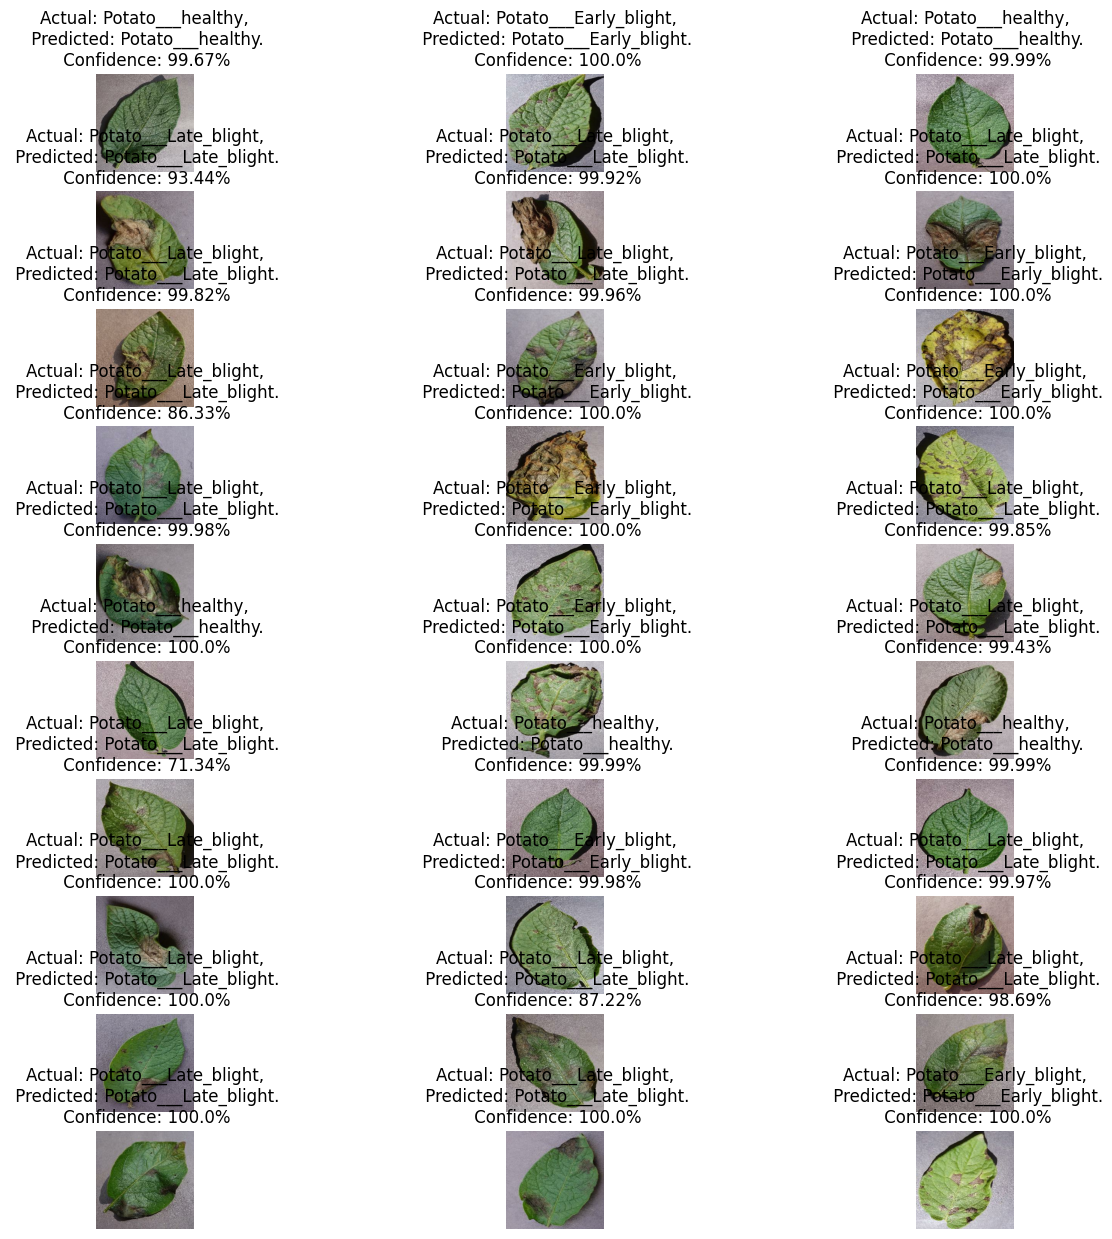

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(30):
        ax = plt.subplot(10, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(new_model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(2):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(new_model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 104ms/step
predicted label: Potato___Early_blight
Confidence 100.0


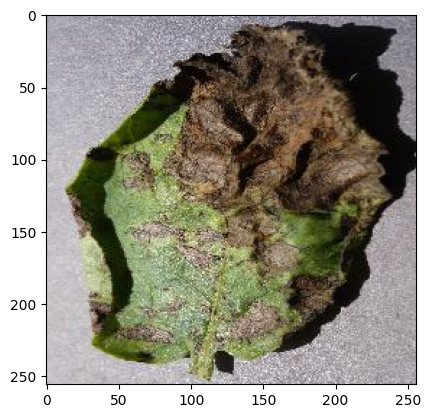

In [ ]:
import numpy as np
for images, labels in test_dataset.take(1):

    first_image = images[31].numpy().astype('uint8')
    first_label = labels[31].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    prediction , confidence = predict(new_model , images[31].numpy())
    print("predicted label:",prediction)
    print('Confidence' , confidence)

In [ ]:

true_labels = []  # To store true class labels
predicted_labels = []  # To store predicted class labels

for images, labels in test_dataset:
    for i in range(images.shape[0]):
        predicted_class, confidence = predict(new_model, images[i].numpy())
        actual_class = class_names[labels[i]]
        # image = images[i]
        # label = labels[i].numpy()

        # # Make a prediction for the current image
        # img_array = tf.keras.preprocessing.image.img_to_array(image.numpy())
        # img_array = tf.expand_dims(img_array, 0)
        # predictions , confidence = model.predict(new_model , img_array)
        # predicted_class = np.argmax(predictions)

        true_labels.append(actual_class)
        predicted_labels.append(predicted_class)

# Create the confusion matrix using tf.math.confusion_matrix
#length = len(class_names)
#confusion = tf.math.confusion_matrix(true_labels, predicted_labels, num_classes=3)

print("True Labels ",true_labels)
print("Predicted Labels ",predicted_labels)


1/1 [==============================] - 0s 42ms/step
True Labels  ['Potato___Late_blight', 'Potato___Late_blight', 'Potato___Late_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___Late_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___Late_blight', 'Potato___Late_blight', 'Potato___Late_blight', 'Potato___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Potato___Late_blight', 'Potato___Late_blight', 'Potato___Late_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___Late_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___Late_blight', 'Potato___Lat

In [ ]:
class_label_map = {
    'Potato___Early_blight': 0,
    'Potato___Late_blight': 1,
    'Potato___healthy': 2
}

true_labels = []  # To store true class labels
predicted_labels = []  # To store predicted class labels Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

for images, labels in test_dataset:
    for i in range(images.shape[0]):
        predicted_class, confidence = predict(new_model, images[i].numpy())
        actual_class = class_names[labels[i]]

        # Map class names to integer labels
        true_labels.append(class_label_map[actual_class])
        predicted_labels.append(class_label_map[predicted_class])

print("True Labels ",true_labels)
print("Predicted Labels ",predicted_labels)
confusion = tf.math.confusion_matrix(true_labels, predicted_labels, num_classes=3)
print(confusion)

1/1 [==============================] - 0s 44ms/step
True Labels  [0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 2, 0, 1, 2, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 2, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]
Predicted Labels  [0, 1, 1, 1, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 

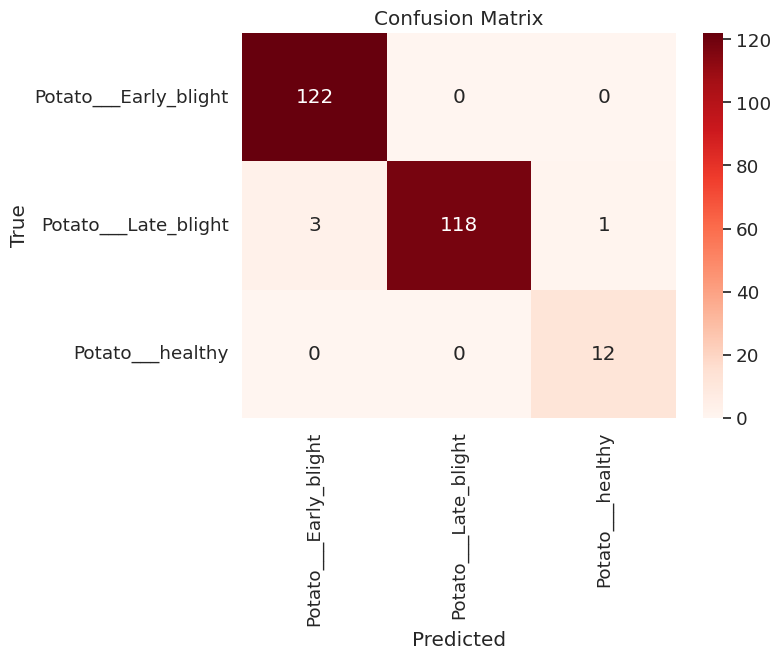

In [ ]:
import seaborn as sns


def show_confusion_matrix(cm, class_names):
    plt.figure(figsize=(7, 5))
    sns.set(font_scale=1.2)  # Adjust the font size if needed
    sns.heatmap(cm, annot=True, cmap="Reds", fmt='g', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming you have your confusion matrix 'confusion' and class names 'class_names'
show_confusion_matrix(confusion, class_names)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# true_labels and predicted_labels are your true and predicted labels, respectively

# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy" , accuracy)
# Precision
precision = precision_score(true_labels, predicted_labels, average='weighted')
print("precision" , precision)
# Recall
recall = recall_score(true_labels, predicted_labels, average='weighted')
print("Recall" , recall)
# F1-score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print("F1" , f1)

Accuracy 0.984375
precision 0.9849567307692307
Recall 0.984375
F1 0.9843940831646424
